# Inport libraries

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
#GPU Information
!nvidia-smi

Fri Jan  6 11:30:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST Dataset files

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Dataloader for MNIST dataset

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, data_df:pd.DataFrame, transform=None, is_test=False):
        super(MNISTDataset, self).__init__()
        dataset = []
            
        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            if is_test:
                label = -1
                image = data.reshape(28, 28).astype(np.uint8)
            else:
                label = data[0]
                image = data[1:].reshape(28, 28).astype(np.uint8)
            
            if transform is not None:
                image = transform(image)
                    
            dataset.append((image, label))
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return self.dataset[i]

In [6]:
data_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train_data = data_train.drop('label', axis=1).values
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
eval_count = 1000
train_transform = transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])
test_transform = val_transform
# train_dataset = MNISTDataset(data_train.iloc[:-eval_count], default_transform)
train_dataset = MNISTDataset(data_train, train_transform) # use this to train the model on the full training set
eval_dataset = MNISTDataset(data_train.iloc[-eval_count:], val_transform)

  0%|          | 0/42000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
data_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_dataset = MNISTDataset(data_test, test_transform, is_test=True)

  0%|          | 0/28000 [00:00<?, ?it/s]

# Original training data format

In [8]:
data_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Unique training labels
data_train.label.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [10]:
# Training samples with label == 1
data_train[data_train.label == 1].to_numpy()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [11]:
row = data_train.iloc[1].to_numpy()
label = row[0]
digit_img = row[1:].reshape(28, 28)
print("label:",label)
# print("image of the digit:\n", digit_img)

label: 0


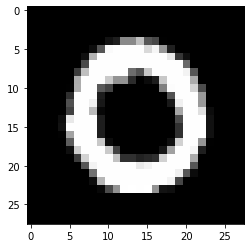

In [12]:
plt.imshow(digit_img, interpolation='nearest', cmap='gray')
plt.show()

# ViT model

I want to use the model described in [this article](https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0).

In [13]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 494.8 kB/s eta 0:00:00


In [14]:
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x
    
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

# Load the MNIST dataset

In [15]:
torch.manual_seed(42)

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

# Train the model 

In [16]:
import torch.nn.functional as F

def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [17]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [18]:
import time

model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train_loss_history, test_loss_history = [], []

In [19]:
N_EPOCHS = 100

# lambda1 = lambda epoch: epoch // 30
# lambda2 = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, eval_loader, test_loss_history)
    scheduler.step()

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1 LR: [0.1]
[    0/42000 (  0%)]  Loss: 2.3232
[10000/42000 ( 24%)]  Loss: 2.1490
[20000/42000 ( 48%)]  Loss: 1.7426
[30000/42000 ( 71%)]  Loss: 1.5050
[40000/42000 ( 95%)]  Loss: 0.9084

Average test loss: 0.4946  Accuracy:  841/ 1000 (84.10%)

Epoch: 2 LR: [0.095]
[    0/42000 (  0%)]  Loss: 0.8241
[10000/42000 ( 24%)]  Loss: 1.0089
[20000/42000 ( 48%)]  Loss: 0.6858
[30000/42000 ( 71%)]  Loss: 0.7181
[40000/42000 ( 95%)]  Loss: 0.4858

Average test loss: 0.1859  Accuracy:  941/ 1000 (94.10%)

Epoch: 3 LR: [0.09025]
[    0/42000 (  0%)]  Loss: 0.5586
[10000/42000 ( 24%)]  Loss: 0.3808
[20000/42000 ( 48%)]  Loss: 0.3384
[30000/42000 ( 71%)]  Loss: 0.3739
[40000/42000 ( 95%)]  Loss: 0.4720

Average test loss: 0.1803  Accuracy:  944/ 1000 (94.40%)

Epoch: 4 LR: [0.0857375]
[    0/42000 (  0%)]  Loss: 0.3308
[10000/42000 ( 24%)]  Loss: 0.2200
[20000/42000 ( 48%)]  Loss: 0.3810
[30000/42000 ( 71%)]  Loss: 0.2285
[40000/42000 ( 95%)]  Loss: 0.3400

Average test loss: 0.1828  Accurac

# Making Predictions on Test data

In [20]:
submission_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    
    for images, _ in submission_loader:
        images = images.to(DEVICE)
        output = F.log_softmax(model(images), dim=1)
        _, pred = torch.max(output, dim=1)
        
        for prediction in pred:
            #print([image_id, prediction.item()])
            submission.append([image_id, prediction.item()])
            image_id += 1
            

In [21]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)
submission_df

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,9
5,5,3
...,...,...
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9


In [22]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)